# Numerical Solution For Finding Langrange Multipliers

In this code we're looking at how to find the values of $\lambda_i$.

We start by defining a set of random c vectors:

In [3]:
import numpy as np
np.set_printoptions(suppress=True, precision=5)


cs = []

for i in range(10):
    cs.append(np.random.randn(7,1))

Note 'ls' is the vector of $\lambda$s:

Here are functions to calculate M, L, dL/dl, one to check the gradient (which we call at the end with a random set of ls).

Note: The functions are written to minimise $\log |M|$ (useful for using the scipy minimize function).

In [4]:
np.set_printoptions(suppress=True, precision=5)
def calcM(ls,cs):
    """
    Find the covariance matrix, M, as the lambda weighted sum of c c^T
    """
    d = len(cs[0])
    M = np.zeros([d,d])
    ccTs = []
    for l,c in zip(ls,cs):        
        ccT = np.dot(c,c.T)
        #print c,ccT,l,M
        M = M + l*ccT       
        ccTs.append(ccT)
    return M

def L(ls,cs):
    """
    Find L = -log |M| + sum(lambda_i * (1-c^T M^-1 c))
    """
    M = calcM(ls,cs)
    Minv = np.linalg.pinv(M)
    t = 0
    for l,c in zip(ls,cs):        
        t += l*(1-np.dot(np.dot(c.T,Minv),c))[0,0]

    return (-np.log(np.linalg.det(M)) + t)
    #return t

#ignore this function (it was for testing)
def shortened_L(ls,cs):
    M = calcM(ls,cs)
    return -(-np.log(np.linalg.det(M)))  

def dL_dl(ls,cs):
    """
    Find the gradient dL/dl_j
    """
    M = calcM(ls,cs)
    Minv = np.linalg.pinv(M)            
    grads = np.zeros(len(ls))    
    for j in range(len(cs)):        
        grads[j] = -np.trace(np.dot(Minv,np.dot(cs[j],cs[j].T)))     
    return np.array(grads)+1
    
def checkgrad(ls,cs):
    approx_dL_dl = []
    d = 0.0001
    for i in range(len(ls)):
        delta = np.zeros_like(ls)
        delta[i]+=d
        approx_dL_dl.append(((L(ls+delta,cs)-L(ls-delta,cs))/(2*d)))
    approx_dL_dl = np.array(approx_dL_dl)

    print "Value:"
    print L(ls,cs)
    print "Approx"
    print approx_dL_dl
    print "Analytical"
    print dL_dl(ls,cs)

    print "Difference"
    print approx_dL_dl-dL_dl(ls,cs)
    print "Ratio"
    print approx_dL_dl/dL_dl(ls,cs)

ls=np.random.rand(len(cs))

checkgrad(ls,cs)

Value:
-6.65549620755
Approx
[-0.71781 -0.35232 -6.99802  0.58674 -0.39791 -0.53393 -2.68435 -1.35602
 -0.68122 -0.54406]
Analytical
[-0.71781 -0.35232 -6.99802  0.58674 -0.39791 -0.53393 -2.68435 -1.35602
 -0.68122 -0.54406]
Difference
[-0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]
Ratio
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


The checkgrad function suggests the gradients are all computed correctly!

In this part I try two ways of optimising,

   1. using the scipy minimize function
   
   2. using my own optimiser

In [5]:
from scipy.optimize import minimize

def maxcMinvc(ls,cs): #this allows us to enforce a bound on the max(c^T M^-1 c) <= 1 (over all c_i)
    M = calcM(ls,cs)
    Minv = np.linalg.pinv(M)
    maxv = -np.Inf
    for l,c in zip(ls,cs):
        v = np.dot(np.dot(c.transpose(), Minv),c)
        if v>maxv:
            maxv = v
    if np.isscalar(maxv):
        return maxv
    else:
        return maxv[0,0]

print maxcMinvc(ls,cs)

def findLambdas(cs):
    ls = np.random.rand(len(cs))+0.5
    rank = np.min([len(cs),len(cs[0])])
    
    #other contstraints
    #cons = ({'type': 'eq', 'fun' : lambda ls: np.sum(ls)-rank},{'type':'ineq','fun':lambda ls:np.min(ls)})
    #cons = ({'type': 'eq', 'fun' : lambda ls: np.sum(ls)-rank},{'type':'ineq','fun':lambda ls:np.min(ls)},{'type':'ineq','fun':lambda ls:1-maxcMinvc(ls,cs)})
    cons = ({'type':'ineq','fun':lambda ls:np.min(ls)},{'type':'ineq','fun':lambda ls:1-maxcMinvc(ls,cs)})
    #cons = ()
    #res = minimize(L, ls, args=(cs), method='BFGS', options={'xtol': 1e-8, 'disp': True})
    #res = minimize(L, ls, args=(cs), method='nelder-mead', options={'xtol': 1e-8, 'disp': True})
    res = minimize(L, ls, args=(cs), method='SLSQP', options={'xtol': 1e-8, 'disp': True}, constraints=cons)
    #res = minimize(L, ls, args=(cs), method='TNC', options={'xtol': 1e-8, 'disp': True}, constraints=cons)
    #res = minimize(L, ls, args=(cs), method='TNC', options={'xtol': 1e-8, 'disp': True}, constraints=cons, jac=dL_dl)
    ls = res.x 
    return ls

ls = findLambdas(cs)
print "Lambdas:"
print ls
print np.sum(ls)

M = calcM(ls,cs)
Minv = np.linalg.pinv(M)
print "Solutions to c^T M^-1 c (should all be 0<=x<=1)"
for l,c in zip(ls,cs):
    print np.dot(np.dot(c.transpose(), Minv),c)
    

7.99802014997
Iteration limit exceeded    (Exit mode 9)
            Current function value: -9.63990359477
            Iterations: 101
            Function evaluations: 1402
            Gradient evaluations: 101
Lambdas:
[ 0.9614   0.13897  0.97277  0.      -0.       0.97788  1.00864  0.99754
  1.00427  0.96032]
7.02177262942
Solutions to c^T M^-1 c (should all be 0<=x<=1)
[[ 0.99912]]
[[ 1.00029]]
[[ 0.99096]]
[[ 0.29621]]
[[ 0.76422]]
[[ 1.00011]]
[[ 0.99121]]
[[ 1.00072]]
[[ 0.99533]]
[[ 1.00058]]


/home/lionfish/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:29: OptimizeWarning: Unknown solver options: xtol
/home/lionfish/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in log


Here's my own gradient descent method.

In [6]:
def findLambdas(cs):
    """
    Gradient descent to find the lambda_is
    
    Parameters:
        cs = list of column vectors (these are the gradients of df*/df_i)
    
    Returns:
        ls, storedls = vector of lambdas, and history of lambdas (for plotting)
        
    """
    
    ls = np.ones(len(cs))*0.7
    
    #learning rate
    lr = 0.01
    Nits = 10000
    storedls = np.zeros([Nits,len(ls)])
    for it in range(Nits): 
        delta_ls = -dL_dl(ls,cs)*lr
        ls =  ls + delta_ls
        ls[ls<0] = 0
        storedls[it,:] = ls
    return ls, storedls

ls, storedls = findLambdas(cs)       
print "Lambdas:"
print ls
M = calcM(ls,cs)
Minv = np.linalg.pinv(M)
print "Solutions to c^T M^-1 c (should all be 0<=x<=1)"
for l,c in zip(ls,cs):
    print np.dot(np.dot(c.transpose(), Minv),c)
    

Lambdas:
[ 0.95975  0.14205  0.96294  0.       0.       0.97757  0.99976  0.99822
  0.99957  0.96014]
Solutions to c^T M^-1 c (should all be 0<=x<=1)
[[ 1.]]
[[ 1.]]
[[ 1.]]
[[ 0.29717]]
[[ 0.76416]]
[[ 1.]]
[[ 1.]]
[[ 1.]]
[[ 1.]]
[[ 1.]]


Pleasingly it matches the optimiser above (which uses approximations to the gradient).

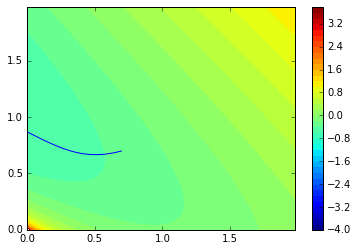

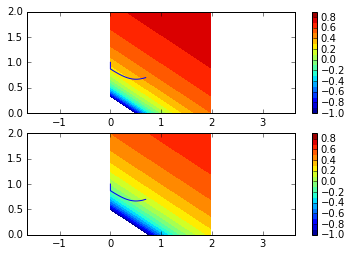

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline


cs = []

for i in range(3):
    cs.append(np.random.randn(2,1))
ls, storedls = findLambdas(cs)       

other = ls[2]
xs = np.arange(0,2,0.02)
ys = np.arange(0,2,0.02)
X, Y = np.meshgrid(xs, ys)
Z = []
for xlist,ylist in zip(X,Y):
    zlist = []
    for x,y in zip(xlist,ylist):
        zlist.append(L(np.array([x,y,other]),cs))
    Z.append(zlist)
Z = np.array(Z)

CS = plt.contourf(X, Y, Z, np.arange(-4,4,0.2))
cbar = plt.colorbar(CS)
plt.plot(storedls[:,0],storedls[:,1])


storedls = np.array(storedls)
plt.figure()

for dim in range(2):
    plt.subplot(2,1,dim+1)
    Z = []
    for xlist,ylist in zip(X,Y):
        zlist = []
        for x,y in zip(xlist,ylist):
            #try:
            grad = dL_dl(np.array([x,y,other]),cs)
            zlist.append(grad[dim])
            #except:
            #    zlist.append(np.nan)

        Z.append(zlist)
    Z = np.array(Z)

    CS2 = plt.contourf(X, Y, Z, np.arange(-1,1,0.1))
    cbar = plt.colorbar(CS2)
    plt.axis('equal')
    plt.plot(storedls[:,0],storedls[:,1])
    

The top figure is the values of L (over two values of $\lambda$).
The bottom two figures are the gradients of $L$, over two values of $lambda$. The first is the gradient wrt to $lambda$ on the x-axis, and the second wrt to the one on the y-axis. So you can see how it follows the gradient down (in this case) to the maximum of $L$, but with the constraint (artificially imposed) that the lambdas must be greater than (or equal to) zero.

So in simple cases it seems to work!

Below are examples of $c$ from real covariance functions, to investigate what structures they might have which cause a problem.

## Problem c values

The problem values of $\mathbf{c}$ previously seemed to occur when I used 'realistic' values. But it may be the new code solves the previous problems. In particular I must have improved things as the new code doesn't require the sum of the lambdas to be enforced (to equal the rank).

The vectors are the columns of:

$$K_{*f} K^{-1}$$

So we can produce some;

In [84]:
import numpy as np
np.set_printoptions(suppress=True, precision=5)


def k(x1,x2):
    return np.exp(-(x1-x2)**2)

X = np.arange(0,60,3.9)
X[-1] = X[-2]+1e-10
X[0:5] = X[10:15]
Xstar = np.arange(50,55,0.2)

Kstarf = np.zeros([len(Xstar),len(X)])
for i,xstar in enumerate(Xstar):
    for j,x in enumerate(X):
        Kstarf[i,j] = k(x,xstar)
        
K = np.zeros([len(X),len(X)])
for i,x1 in enumerate(X):
    for j,x2 in enumerate(X):
        K[i,j] = k(x1,x2)
        
K = K + np.eye(len(K))*0.0001
C = np.dot(Kstarf,np.linalg.inv(K))

cs = []
for i in range(C.shape[1]):
    cs.append(C[:,i][:,None])

In [85]:
ls, storedls = findLambdas(cs)
print "Lambdas:"
print ls
M = calcM(ls,cs)
Minv = np.linalg.pinv(M)
print "Solutions to c^T M^-1 c (should all be 0<=x<=1)"
for l,c in zip(ls,cs):
    print np.dot(np.dot(c.transpose(), Minv),c)

Lambdas:
[ 0.       0.       0.5      0.5      0.50015  0.       0.       0.       0.
  0.       0.       0.       0.5      0.5      0.49985  1.     ]
Solutions to c^T M^-1 c (should all be 0<=x<=1)
[[ 0.]]
[[ 0.]]
[[ 1.]]
[[ 1.]]
[[ 1.00001]]
[[ 0.]]
[[ 0.]]
[[ 0.]]
[[ 0.]]
[[ 0.]]
[[ 0.]]
[[ 0.]]
[[ 1.]]
[[ 1.]]
[[ 1.00001]]
[[ 1.]]
